In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math

In [33]:
df = pd.read_csv('Data/cleaned.csv')

In [34]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled


In [68]:
df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

### Feature Engineering on Dates

In [39]:
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    
    df.drop(columns='date', inplace=True)

In [40]:
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day

In [41]:
process_arrival_date(df)

In [42]:
process_booking_date(df)

In [43]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'arrival_week', 'arrival_dayofweek', 'arrival_quarter',
       'arrival_dayofyear', 'booking_date', 'booking_year', 'booking_month',
       'booking_week', 'booking_dayofweek', 'booking_quarter',
       'booking_dayofyear'],
      dtype='object')

#### Barplots showing the total number of booking, lines showing the canceled booking

In [85]:
def plot_dots_ordinal(feature, ax):
    dots = df.groupby(feature)['booking_status'].sum().reset_index()
    dots.sort_values(feature, inplace=True)
    train_containers = ax.containers[0]
    
    containers = [train_containers]
    
    for container in containers:
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots.booking_status
        x_s = x_s[:y_s.shape[0]]
        ax.plot(x_s, y_s, marker='.', alpha=0.8, markersize=10)

In [79]:
columns = ['booking_year', 'booking_quarter', 'booking_month', 'booking_dayofweek', 
           'booking_date', 'booking_week', 'booking_dayofyear']
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)

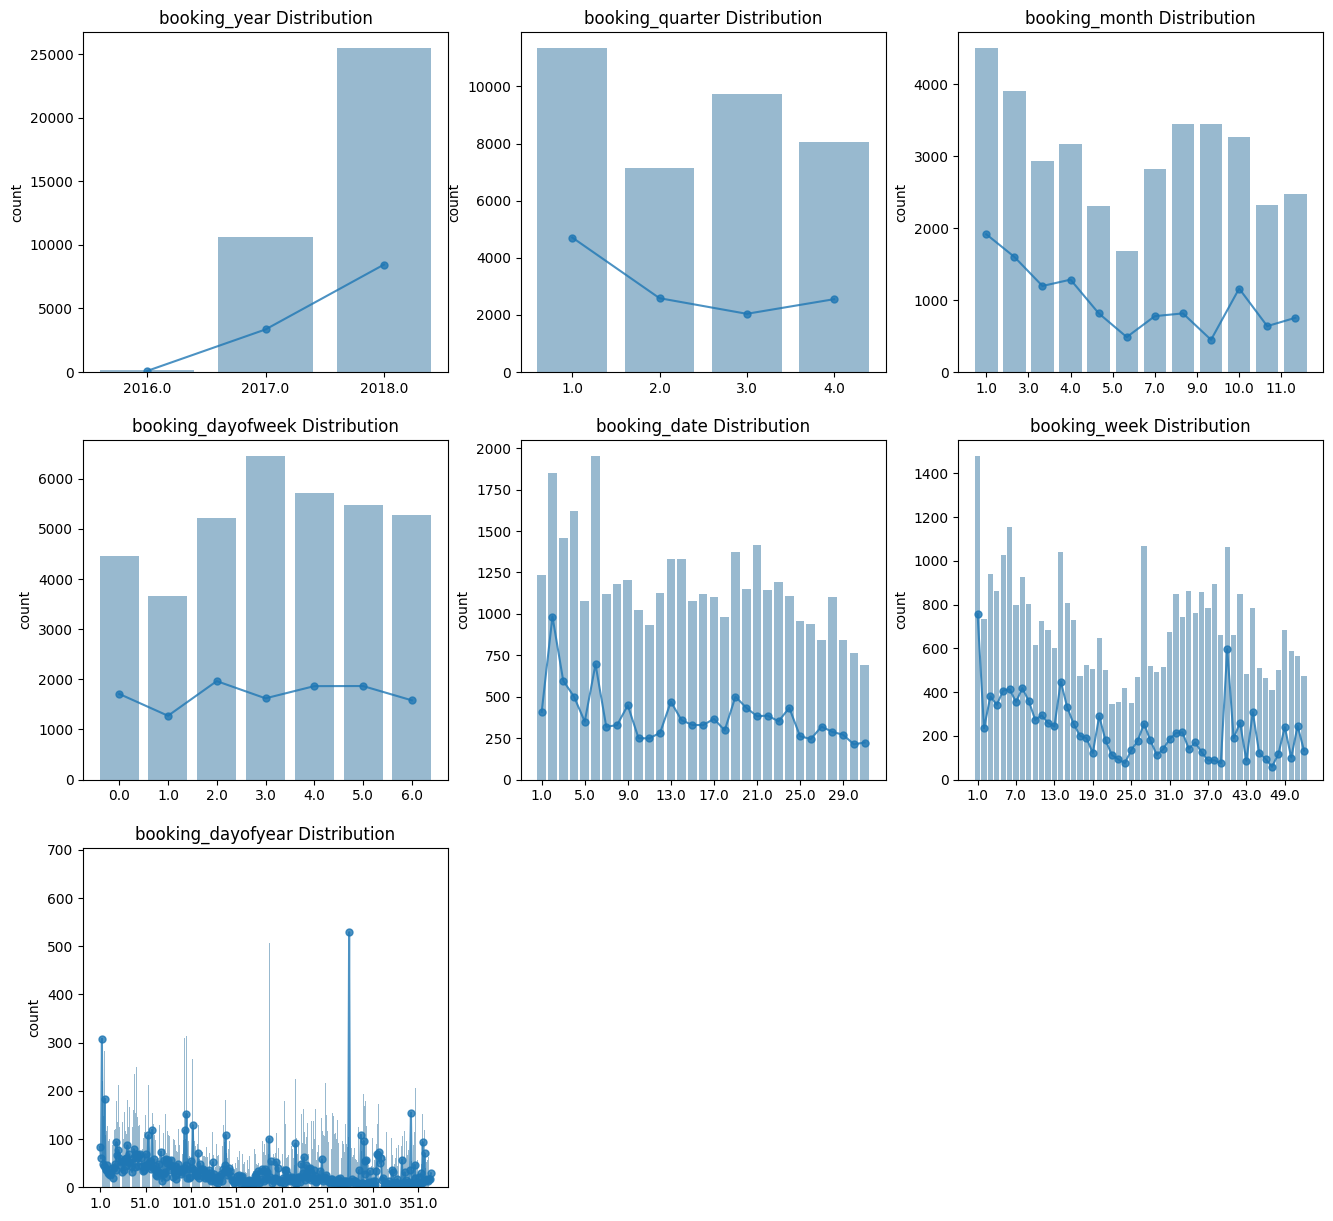

In [86]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    column = columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

In [87]:
columns = ['arrival_year', 'arrival_quarter', 'arrival_month', 'arrival_dayofweek', 
           'arrival_date', 'arrival_week', 'arrival_dayofyear']
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)

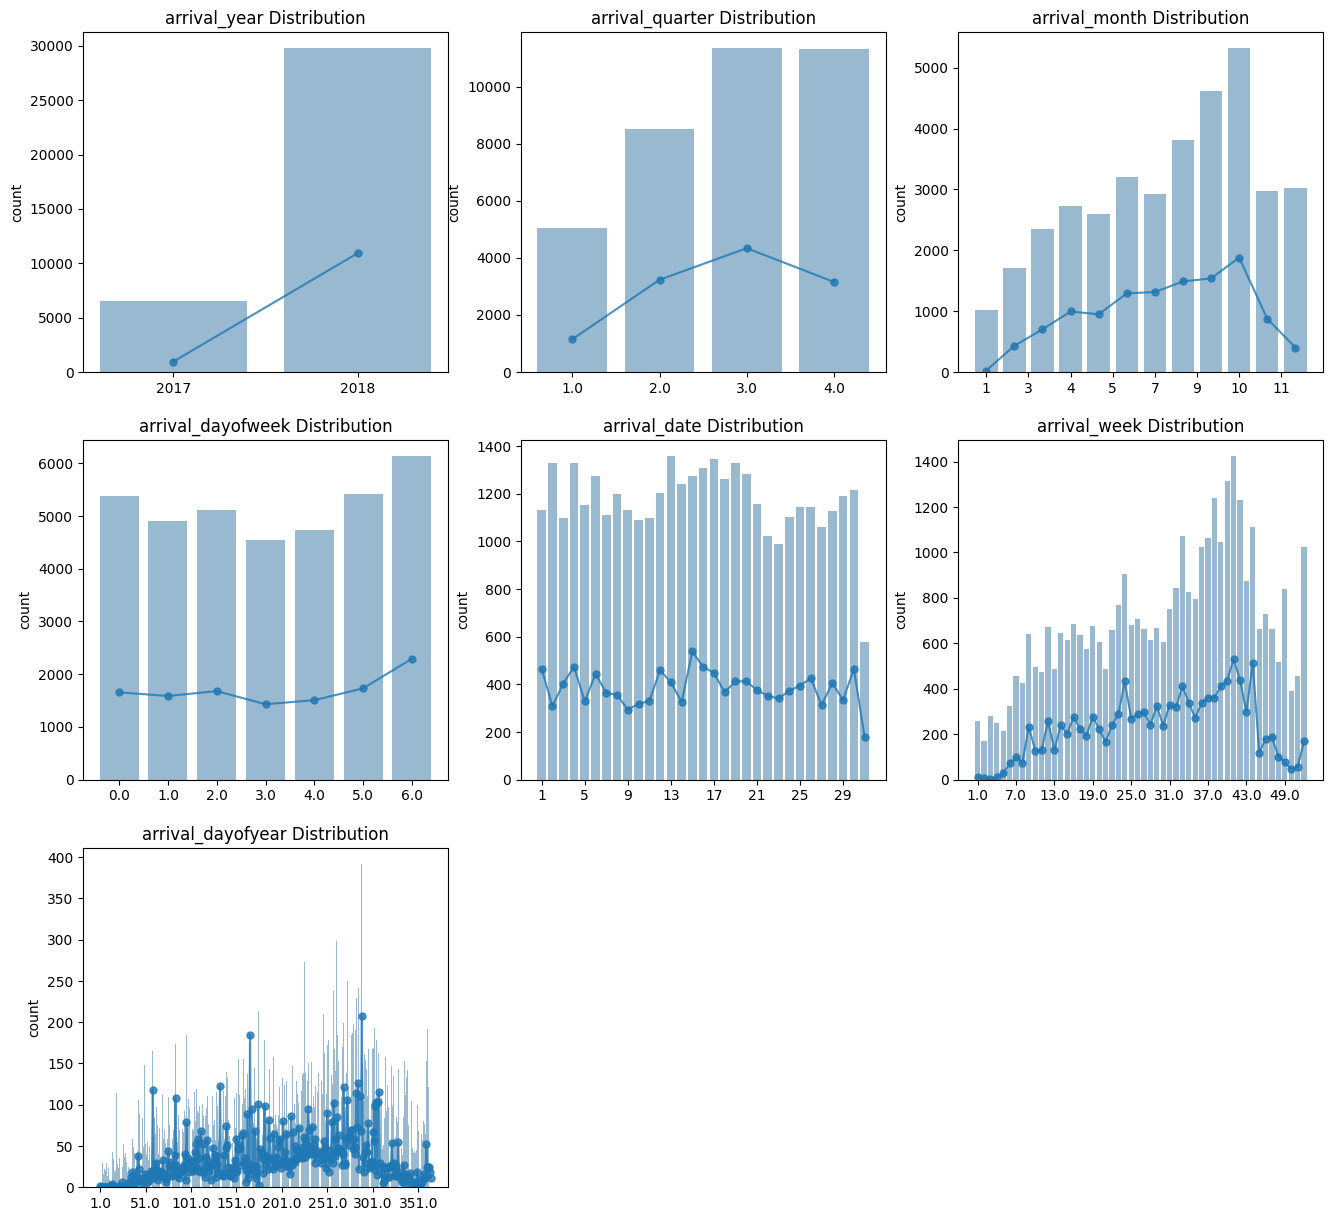

In [88]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    column = columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    